# 15. Deep learning

Deep learning methods are used more and more fequently for complex segmentation tasks. The basic idea of that approach is to let a system learn by itself what are the important features of the objects to segment by feeding it training examples.

Of course you will not learn all the details about deep learning in this single notebook. The goal here is simply to give a very brief overview of the steps involved. In particular the goal is to show that if you are provided with a trained network *e.g.* by a collaborator, using it to segment your data is very straightforward.

The example here uses Tensorflow and Keras. Tensorflow is Google's deep learning library that is widely used. Keras is a layer that sits on top of tools like Tensorflow and allows one to simplify the prototyping of a deep learning pipeline. It can also transparently be used with other "backends" like PyTorch, Facebook's deep learning library.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.external.tifffile import TiffFile
from skimage.measure import label, regionprops
from skimage.segmentation import watershed

#import your function
import sys, os
from course_functions import detect_nuclei

if not os.path.isdir('MyData/DL'):
    os.makedirs('MyData/DL')

## 15.1 Creating the training set

As a simple example, we are going to use the Zebra fish embryo *nuclei* that we have tried to segment before. Usually, one would create a training set by manually segmenting data or at least manually correcting them. Here we cheat and use our previous segmentation pipeline to create a learning dataset.

First we have to decide how large our training images are going to be. This is set by the type of computing resource used and the memory size.

In [3]:
imsize = 64
image_rows = 64
image_cols = 64
channels = 1


In [4]:
#load the image to process
data = TiffFile('Data/30567/30567.tif')
image = data.pages[0].asarray()
per_image = np.floor(np.array(image.shape)/imsize)

To create our training set, we are going to segment 5 images using our previous pipeline. Then we are going to cut the original image and its mask into 64x64 pieces. We exclude images which have no nuclei as they don't contain interesting information.

/usr/local/lib/python3.5/dist-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 14 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


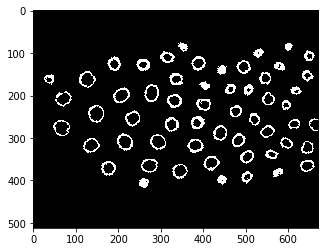

In [5]:
all_images = []
all_masks = []
for t in (3,13,23,33,43):
    image = data.pages[t].asarray()
    im_float = image.astype(np.float32)
    #create your mask
    nuclei = detect_nuclei(image)
    nuclei = nuclei.astype(np.uint8)
    
    for i in range(int(per_image[0])):
        for j in range(int(per_image[1])):
            if np.sum(nuclei[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize])>1:
                all_images.append(im_float[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize])
                all_masks.append(nuclei[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize])

plt.imshow(nuclei, cmap = 'gray')

Here we could split our dataset into a training and testing set. We have enough other data so we use all examples for training.

In [6]:
num_images = 5
total = len(all_masks)

num_train = int(0.99*total)
num_test = total-num_train
print(total)
print(num_train)
print(num_test)


283
280
3


Now we create empty arrays that are going to contain all our data. Note that this works only if the data are not too large or you have a computer with **a lot of RAM**. The alternative is to use a more complex approach using Python generators, which are going to *serve* images sequentially.

In [7]:
imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight[:]=1

Now we fill up our containers. Note that they have to be in special shapes to be fed correctly to the network. Also, in addition to our images and masks, we have so-called weights. This is an image that is going to assign more importance to certain regions. This is important for example if one category of pixels appears much less than another, like in our case nuclei vs. background.

Note also that we correct all images by normalizing them to avoid extreme values.

In [8]:
for counter in range(total):
    if counter<num_train:
        imgs[counter] = all_images[counter][..., np.newaxis]
        imgs_mask[counter] = all_masks[counter]
        imgs_weight[counter] = 10*all_masks[counter]+1
    else:
        imgs_test[counter-num_train] = all_images[counter][..., np.newaxis]
        imgs_id[counter-num_train] = counter-num_train

mean_val = np.mean(imgs)
imgs = imgs - mean_val
std_val = np.std(imgs)
imgs = imgs/std_val

np.save('MyData/DL/'+'imgs_train.npy', imgs)
np.save('MyData/DL/'+'imgs_mask_train.npy', imgs_mask.reshape((num_train,image_rows*image_cols)))
np.save('MyData/DL/'+'imgs_test.npy', imgs_test)
np.save('MyData/DL/'+'imgs_id_test.npy', imgs_id)
np.save('MyData/DL/'+'imgs_weight_train.npy', imgs_weight.reshape((num_train,image_rows*image_cols)))


## 15.2 Training the network

Now we can import our small deep learning module.

In [9]:
import deeplearning

Using TensorFlow backend.


And we can run the training of our network.

In [11]:
image_rows = 64
image_cols = 64

#deeplearning.nuclei_train('MyData/DL/', image_rows,image_cols, dims=1, batch_size = 10, epochs = 100, weights = None)
deeplearning.nuclei_train('MyData/DL/', image_rows,image_cols, dims=1, batch_size = 10, epochs = 10, weights = None)

Train on 224 samples, validate on 56 samples
Epoch 1/10
224/224 [==============================] - 30s 134ms/step - loss: 0.9972 - dice_coef: 0.3031 - val_loss: 0.4593 - val_dice_coef: 0.3932
Epoch 2/10
224/224 [==============================] - 28s 126ms/step - loss: 0.3411 - dice_coef: 0.5606 - val_loss: 0.2240 - val_dice_coef: 0.6404
Epoch 3/10
224/224 [==============================] - 22s 97ms/step - loss: 0.1893 - dice_coef: 0.7272 - val_loss: 0.1442 - val_dice_coef: 0.7747
Epoch 4/10
224/224 [==============================] - 21s 94ms/step - loss: 0.1358 - dice_coef: 0.8080 - val_loss: 0.1444 - val_dice_coef: 0.7878
Epoch 5/10
224/224 [==============================] - 21s 95ms/step - loss: 0.1316 - dice_coef: 0.8231 - val_loss: 0.1267 - val_dice_coef: 0.7974
Epoch 6/10
224/224 [==============================] - 21s 95ms/step - loss: 0.1203 - dice_coef: 0.8308 - val_loss: 0.1128 - val_dice_coef: 0.8404
Epoch 7/10
224/224 [==============================] - 21s 95ms/step - loss: 0

## 15.3 Using the trained network

Let's load an image that we did **not** use for training and select a 512x512 region.

In [ ]:
image = data.pages[143].asarray()[0:512,0:512]
im_float = image.astype(float)

Now we load again the network and say what the input size will be. Then **most importantly**, we use the weights that we just trained.

In [ ]:
model = deeplearning.get_unet(1,512,512)
model.load_weights('MyData/DL/weights.h5')

We correct now this single picture **with the same factors** used for the training set, so that it is in the same *state*.

In [ ]:
imgs_test = im_float.astype('float32')
imgs_test = imgs_test
imgs_test = imgs_test - mean_val
imgs_test = imgs_test/std_val
plt.imshow(imgs_test)
plt.show()

Finally we reshape it to fit into the network and use the predict() function to generate a prediction for each pixel to be foreground or background.

In [ ]:
imgs_test = imgs_test[np.newaxis,...,np.newaxis]
imgs_mask_test = model.predict(imgs_test, verbose=1)
imgs_mask_test = np.reshape(imgs_mask_test,imgs_test.shape)

Finally we can plot the resulting image, which has values from 0 to 1.

In [ ]:
plt.imshow(imgs_mask_test[0,:,:,0], vmin = 0, vmax = 1, cmap= 'gray')
plt.show()

We can now set a threshold for what should be considerd foreground to generate a mask, and compare to the previous segmentation.

In [ ]:
nuclei = detect_nuclei(image)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgs_mask_test[0,:,:,0]>0.9, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(nuclei[0:512,0:512], cmap = 'gray')
plt.show()